# Simplification of roundabouts

Analysis using street network can be sensitive to the actual geometry representation. For example, one roundabout can be typically represented as 4 or more nodes, while it is topologically only one. Hence measurements attempting to capture topology (e.g. centrality) or node density will be skewed.

The following code exemplifies a simple process for road network simplification of roundabouts using `momepy.roundabout_simplification()`.

For this example we will fetch some data from [OpenStreetMap](https://www.openstreetmap.org/#map=6/40.007/-2.488) (using `osmnx`). However, most other data sources should also work as long as their topology has been corrected and can be stored in a GeoDataFrame.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy as mm
import osmnx as ox

## Load data
Using `osmnx` download a neighborhood and reproject to its local CRS.

Two things are required to achieve good results:
1. Reproject the network to a projected CRS (in meters)
1. Transform the graph to an undirected graph:
    -  This helps to remove overlapping LineStrings once moving to GeoDataFrame.


In [2]:
place = "Chamberi, Madrid"

G = ox.graph_from_place(place, network_type="drive", simplify=True)
G_projected = ox.project_graph(G)

edges = ox.graph_to_gdfs(
    ox.convert.to_undirected(
        G_projected
    ),  # prevents some (semi)duplicate geometries
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
)

edges.head(3)

osmid  highway lanes maxspeed  \
u         v         key                                      
22022145  630734756 0      4950643  primary     4       50   
630734756 22022227  0      4950641  primary     4       50   
          141870722 0    131450468  primary     4       50   

                                       name  oneway  reversed     length  \
u         v         key                                                    
22022145  630734756 0     Calle de Carranza    True     False  73.159523   
630734756 22022227  0    Glorieta de Bilbao    True     False  38.431266   
          141870722 0    Glorieta de Bilbao    True     False  20.976139   

                                                                  geometry  \
u         v         key                                                      
22022145  630734756 0    LINESTRING (440346.763 4475626.335, 440393.752...   
630734756 22022227  0    LINESTRING (440417.448 4475607.745, 440441.133...   
          141870722 0    LINESTRING (440411.787 4475627.727, 440413.3 4...   

                              from         to width access tunnel junction  
u         v         key                                                     
22022145  630734756 0     22022145  630734756   NaN    NaN    NaN      NaN  
630734756 22022227  0    630734756   22022227   NaN    NaN    NaN      NaN  
          141870722 0    141870722  630734756   NaN    NaN    NaN      NaN

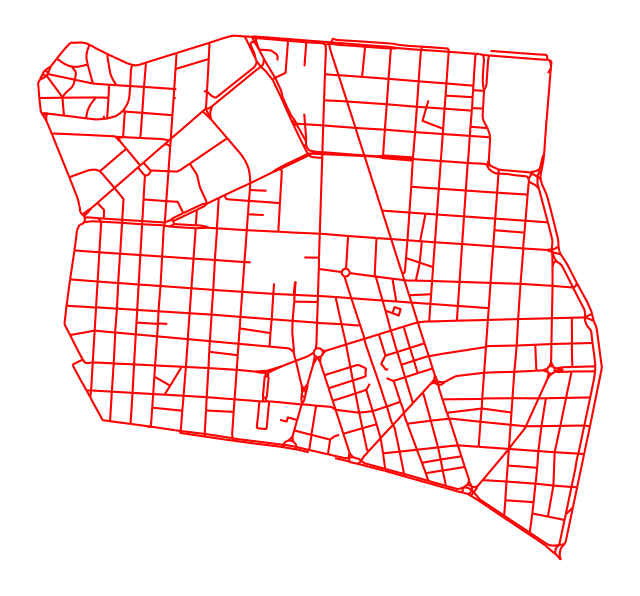

In [3]:
ax = edges.plot(figsize=(8, 12), color="red")
ax.set_axis_off()

## Default behavior

In [4]:
edges_output = mm.roundabout_simplification(edges)

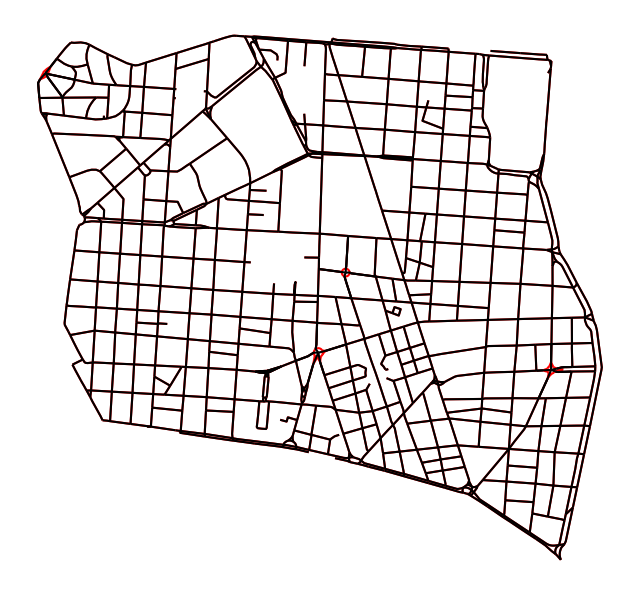

In [5]:
ax = edges.plot(figsize=(8, 12), color="red")
edges_output.plot(ax=ax, figsize=(8, 12), color="black")

ax.set_axis_off()

Using the output column `'simplification_group'` we can count the number of roundabouts that were simplified:

In [6]:
edges_output.simplification_group.nunique()

5

In total **7** roundabouts were simplified, and most of their incoming edges were also considered during the process. 

Let's look at them individually.

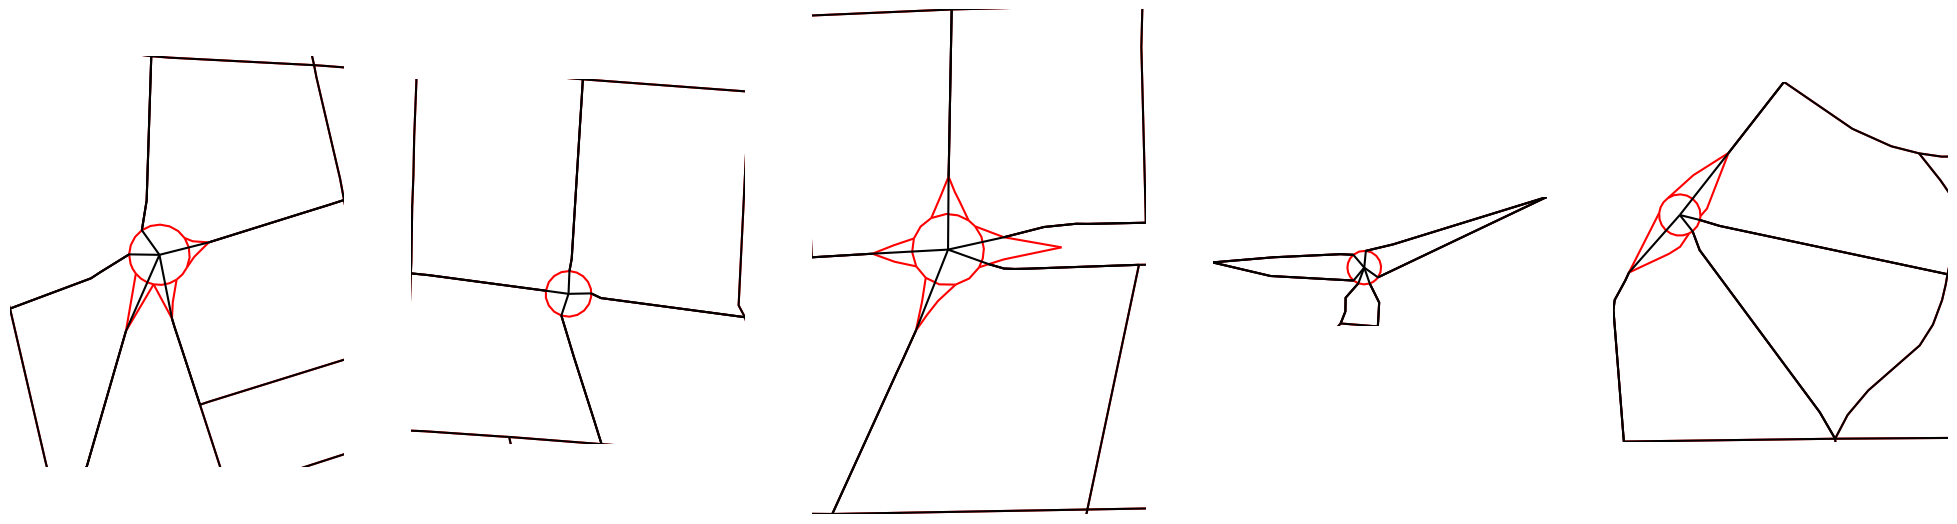

In [7]:
simplification_groups = edges_output.simplification_group.unique()[1:]

fig, axs = plt.subplots(1, len(simplification_groups), figsize=(25, 7))
axs = axs.flatten()

for i in simplification_groups:
    mask = edges_output.simplification_group == i
    minx, miny, maxx, maxy = edges_output[mask].geometry.total_bounds

    edges.plot(ax=axs[i], color="red")
    edges_output.plot(ax=axs[i], color="black")

    axs[i].set_xlim(minx, maxx)
    axs[i].set_ylim(miny, maxy)
    axs[i].set_axis_off()

plt.show()

It's worth investigating why some roundabouts are still missing from simplification. Since the selection of roundabouts is based on the resulting polygons after polygonizing the road network let's use the circular compactness (measurable as `momepy.CircularCompactness`) parameter of the resulting polygons as the main selection attribute.

In [8]:
from shapely.ops import polygonize

polys = gpd.GeoDataFrame(
    geometry=list(polygonize(edges.geometry)), crs=edges.crs
)
circom_serie = mm.circular_compactness(polys)
polys.loc[:, "circom"] = circom_serie

The `circom_threshold` parameter (default = 0.7) establishes the limit at which roundabouts should be selected.

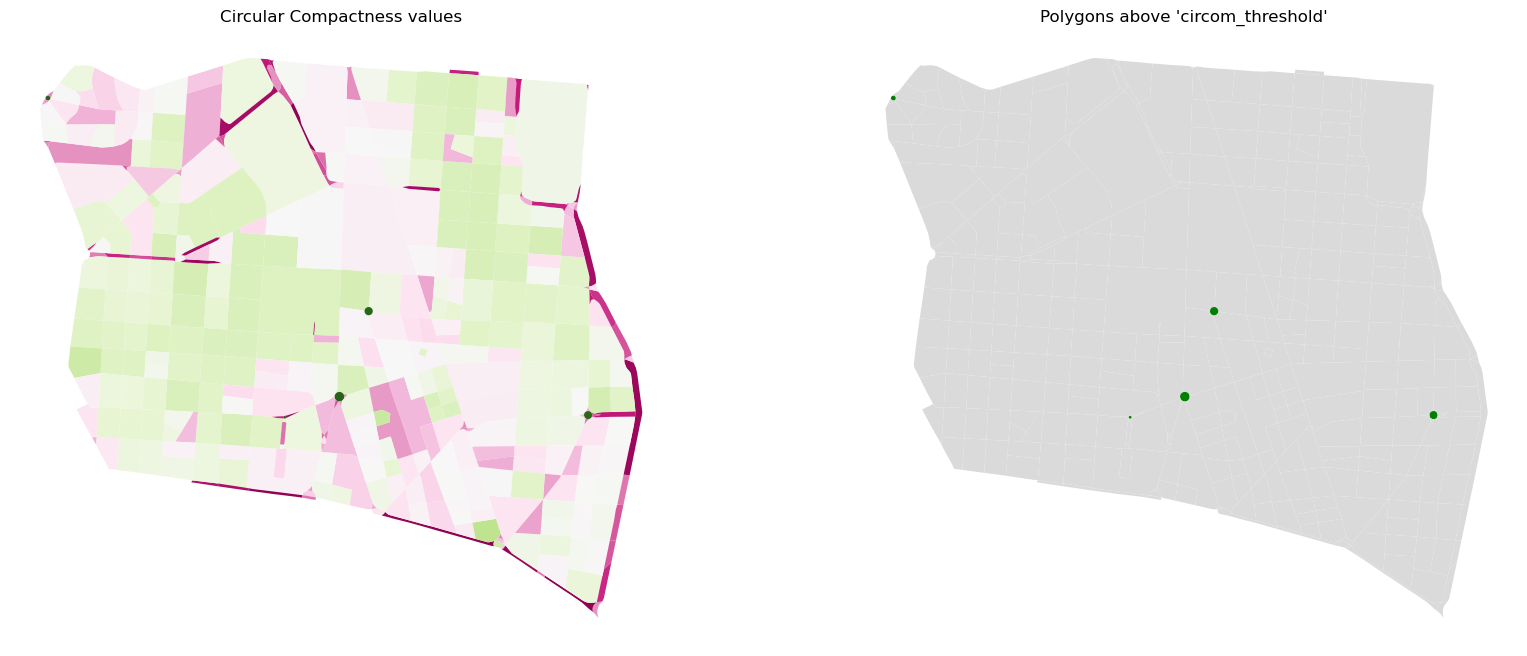

In [9]:
circom_threshold = 0.7
mask = circom_serie > circom_threshold
colors = ["green" if m else "#dbdada" for m in mask]

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

polys.plot(ax=axs[0], column="circom", cmap="PiYG")
axs[0].set_axis_off()
axs[0].title.set_text("Circular Compactness values")

polys.plot(ax=axs[1], color=colors)
axs[1].set_axis_off()
axs[1].title.set_text("Polygons above 'circom_threshold' ")

Let's see the following two **false negatives**:

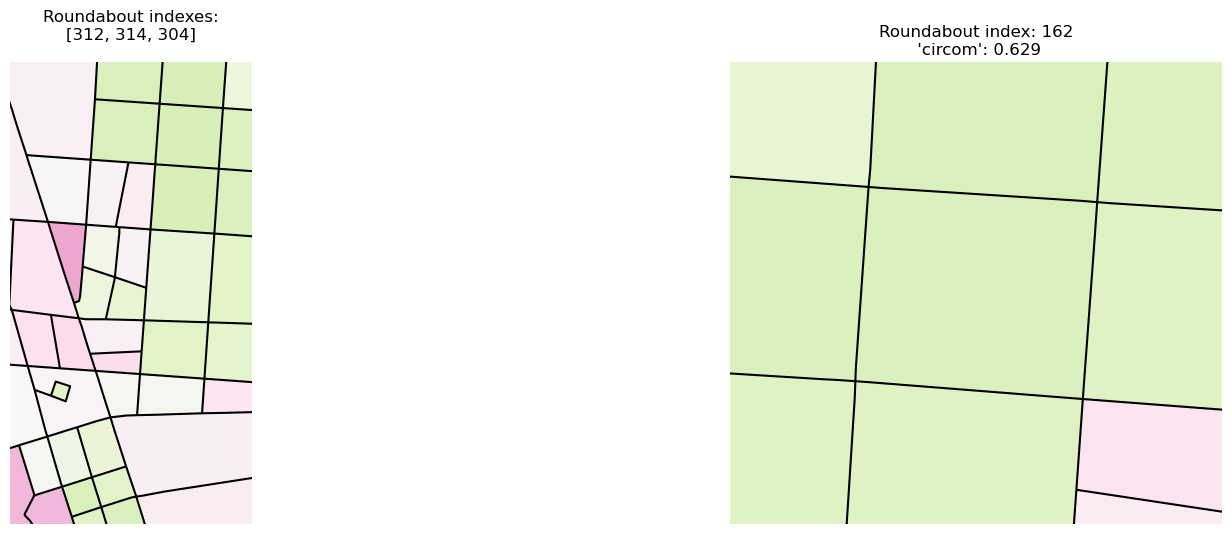

In [10]:
false_negatives = [[312, 314, 304], 162]


fig, axs = plt.subplots(1, 2, figsize=(20, 6))


edges.plot(ax=axs[0], color="black")
polys.plot(ax=axs[0], column="circom", cmap="PiYG")
minx, miny, maxx, maxy = polys.loc[false_negatives[0]].geometry.total_bounds
axs[0].set_xlim(minx - 75, maxx + 75)
axs[0].set_ylim(miny - 75, maxy + 75)
axs[0].set_axis_off()
axs[0].title.set_text("Roundabout indexes:\n" + str(false_negatives[0]))

edges.plot(ax=axs[1], color="black")
polys.plot(ax=axs[1], column="circom", cmap="PiYG")
minx, miny, maxx, maxy = polys.loc[false_negatives[1]].geometry.bounds
label_str = str(round(polys.loc[false_negatives[1]].circom, 3))

axs[1].set_xlim(minx - 75, maxx + 75)
axs[1].set_ylim(miny - 75, maxy + 75)
axs[1].set_axis_off()
axs[1].title.set_text("Roundabout index: 162\n 'circom': " + label_str)

The above helps to exemplify two main reasons why some roundabouts are not being selected:
1. They are crossed by other roads; which breaks them into multiple polygons
    - eg. `index`: `[314, 312, 304]`
1. They don't meet the `circom_threshold`
     - eg. `index`: `[162]` --> (0.676) 
     
## Adapting parameters
Finally, let's also explore what the outcome would look like if we lower the `circom_threshold` and `include_adjacent` is set to `False` 

In [11]:
edges_output_65 = mm.roundabout_simplification(
    edges, circom_threshold=0.65, include_adjacent=False
)

m = edges.explore(color="black", tiles="CartoDB positron")
edges_output.explore(m=m, color="red")
edges_output_65.explore(m=m, color="blue")
m

In [12]:
edges_output_65.simplification_group.nunique()

9

Even though we have been able to simplify **13** supposedly polygons, this sample now contains some false positives. So it is up to the user to decide the right balance to make the most of this simplification.

Note that this is a work in progress and some upcoming enhancements are expected to complement this simplification.